# Generation of Lines and Analysis of the Intensity along the Track 

## Dependencies

In [1]:
import astropy.io.fits as fits
import scipy
from scipy import ndimage
from scipy.optimize import curve_fit, leastsq
from matplotlib import pyplot as plt
import numpy as np
from detectsat.utils.mosaic import *
import imageio as imgio
import math
from random import randrange

## Sinus Function

In [2]:
def sinus(angle, ampl, freq, phase_shift, vertical_shift):
    return ampl*np.sin(freq*math.pi*2*angle+phase_shift)+vertical_shift

## Utils Functions 

In [3]:
def createImage(name, array):
    imgio.imwrite(name, array)

In [4]:
def showGraph(array):
    plt.plot(array)
    plt.show()

In [5]:
def createFitsFile(name, array):
    hdu = fits.PrimaryHDU(array)
    hdu.writeto(name+'.fits')

## Add the line on the data

In [6]:
def addLineOnData(line, data):
    #For the first block of the fits file (bottom left)
    min_x, min_y = 100, 100
    max_x, max_y = 2000, 4000
    height, width = np.shape(line)
    new_data = data.copy()
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    new_data[min_y:min_y+height, min_x:min_x+width] += line[:,:]
    #print('-----------------------')
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    return new_data

## Get the value of the line by using a mask

In [49]:
def get_line_values_with_mask(mask, data, x_start, y_start):
    height, width = np.shape(mask)
    line_values = mask.copy()
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    line_values[:] = mask[:,:]*data[y_start:y_start+height, x_start:x_start+width]
    return np.nan_to_num(line_values)

## Find the intensity along the track

In [63]:
def findIntensityAlongTheLine(data, height_line, width_line, start_line_x, start_line_y, show_graph='True'):
    THRESHOLD = 100
    
    intensities = []
    for i in range(width_line):
        intensity_for_this_x = 0
        for j in range(height_line):
            intensity_for_this_x += data[start_line_y+j,start_line_x+i]
        intensities.append(intensity_for_this_x)
        #intensities.append(intensity_for_this_x/height_line)


    if show_graph:    
        fig, ax = plt.subplots(1, 2)
        ax = ax.flatten()
        ax[0].plot(intensities)
        ax[0].set_title("Original signal")

    intensities_fft = np.fft.fft(intensities)
    intensities_fft = intensities_fft[:round(width_line/2)]
    intensities_fft = np.abs(intensities_fft)
    intensities_fft[0] = 0
    intensities_fft = intensities_fft/max(intensities_fft)
    freq_x_axis = np.linspace(0, width_line/2, len(intensities_fft))
    if show_graph:  
        ax[1].plot(freq_x_axis, intensities_fft, "o-")
        ax[1].set_title("Frequency magnitudes")
        ax[1].set_xlabel("Frequency")
        ax[1].set_ylabel("Magnitude")
    
        plt.grid()
        plt.tight_layout()
        plt.show()
    
        showGraph(intensities_fft)
        print("Frequency magnitudes")
        print('')
    
    bp=intensities_fft[:]
    ibp=scipy.ifft(bp)
    
    intensities_fft_test = np.fft.fft(ibp)
    intensities_fft_test = intensities_fft_test[:round(width_line/2)]
    intensities_fft_test = np.abs(intensities_fft_test)
    intensities_fft_test[0] = 0
    intensities_fft_test = intensities_fft_test/max(intensities_fft_test)
    
    if show_graph:  
        showGraph(ibp)
        print("Inverse Fourier signal")
        print('')
    
    f_loc = np.argmax(intensities_fft_test) # Finds the index of the max
    
    while f_loc > THRESHOLD:
        intensities_fft_test[f_loc] = 0
        f_loc = np.argmax(intensities_fft_test)
    
    f_val = freq_x_axis[f_loc] # The strongest frequency value
    
    print(f"The strongest frequency is f = {f_val}")

    guess_mean = np.mean(intensities)
    guess_phase = 0
    guess_freq = f_val/width_line
    guess_amp = np.std(intensities) * 2.**0.5
    

    x_val = np.arange(width_line)
    if show_graph:
        showGraph(np.transpose(intensities))
    params, _ = curve_fit(sinus, x_val, intensities, [guess_amp, guess_freq, guess_phase, guess_mean])
    print(params)
    
    if show_graph:  
        plt.scatter(x_val, intensities, label='Data')
        plt.plot(x_val, sinus(x_val, params[0], params[1], params[2], params[3]), color='red', label='Fitted function')
        plt.legend(loc='best')
        plt.show()
    
    return params[1]

## Recast the frequency

In [60]:
# Calculation to cast the frequency found to real speed
def recast_freq(freq_found):
    altitude_satellite = 36000000 #altitude of geostationary satellites in [m]
    #altitude_satellite = 35500000 #altitude of ARIANE 2 DEB in [m]
    speed_satellite = 3065 #speed of geostationary satellites in [m/s]
    arcsec_by_pixel = 0.21
    one_cycle_in_pixel = 1/freq_found
    arcsec_by_cycle = arcsec_by_pixel*one_cycle_in_pixel
    distance_one_cycle = altitude_satellite*(math.pi/180*arcsec_by_cycle/3600)
    rotation_rate = speed_satellite/distance_one_cycle # in [1/s]
    spatial_rotation_scale = distance_one_cycle/arcsec_by_cycle # in [m/arc second] 
    return rotation_rate, spatial_rotation_scale

 ## Test findIntensity

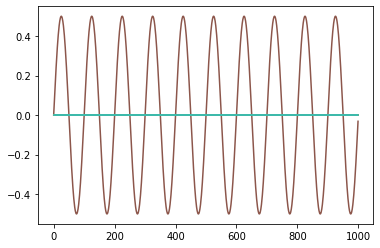

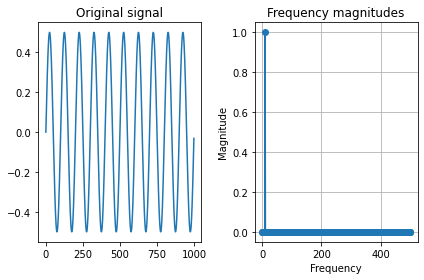

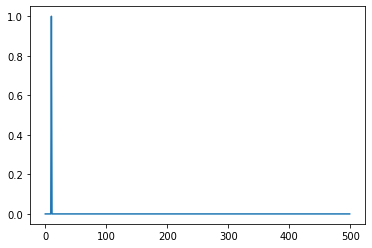

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


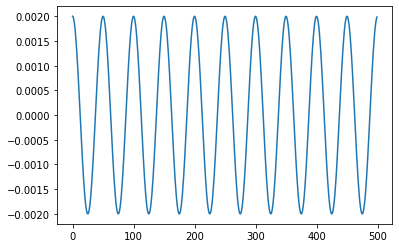

Inverse Fourier signal

The strongest frequency is f = 10.020040080160319


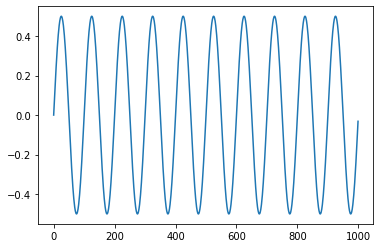

[ 4.99999999e-01  9.99999998e-03  2.92908243e-08 -6.68895005e-10]


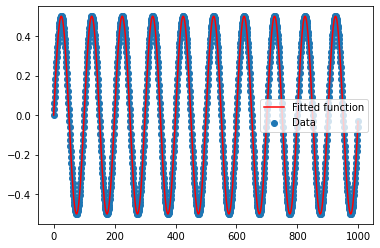

In [61]:
def test_line(): 
    ampl, freq, phase_shift, vertical_shift = 0.5, 0.01, 0, 0
    radius = 15
    width_line = 1000
    height_line = 2*radius
    line = np.zeros((height_line, width_line))
    for i in range(height_line):
        for j in range(width_line):
            if(i == round(height_line/2)):
                line[i,j] = sinus(j, ampl, freq, phase_shift, vertical_shift)
                
    showGraph(np.transpose(line))
    findIntensityAlongTheLine(line, height_line, width_line, 0, 0)
    
test_line()

 # On self generated data

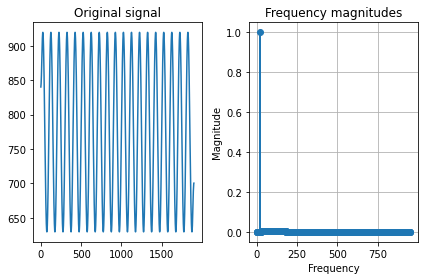

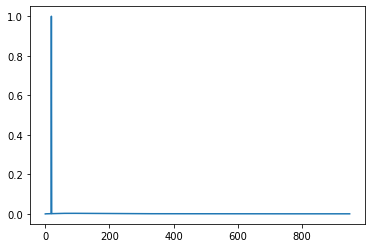

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


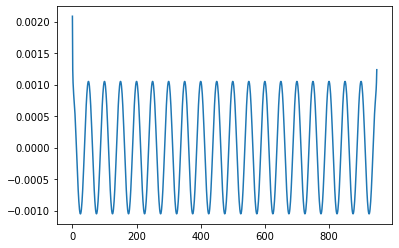

Inverse Fourier signal

The strongest frequency is f = 19.020021074815595


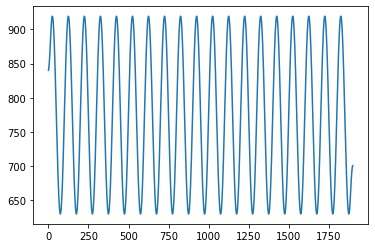

[1.45108799e+02 9.99755292e-03 5.00261753e-02 7.74433257e+02]


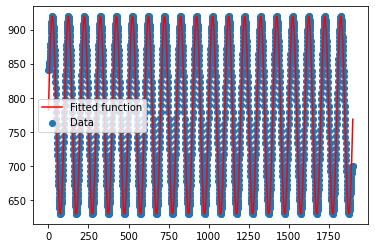

0.00999755291574661

In [22]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
x_star,y_star = 1665,8346
radius = 15
height = 2000
width_line = 1900
height_line = 2*radius
#value = 0.02 #number1
value = 0.01 #number2
#value = 0.008 #number3
#value = 0.008
#ampl, freq, phase_shift, vertical_shift = 0.01, 0.01, 0, 0.5 #number1
ampl, freq, phase_shift, vertical_shift = 0.05, 0.01, 0, 3 #number2
#ampl, freq, phase_shift, vertical_shift = 0.03, 0.01, 0, 2.5 #number3
#ampl, freq, phase_shift, vertical_shift = 0.03, 0.01, 0, 2.5

data = fits.open(name_file)[0].data
star = data[y_star-radius:y_star+radius, x_star-radius:x_star+radius]
line = np.zeros((height_line, width_line))

for i in range(height_line):
    for j in range(width_line):
        if(i == round(height_line/2)):
            #line[i,j] = sinus(j, ampl, period, phase_shift, vertical_shift)
            line[i,j] = value*sinus(j, ampl, freq, phase_shift, vertical_shift)

line_convolved = ndimage.convolve(line, star)
line_convolved[-1,:] = line_convolved[0,:]
#line_convolved[:,:] = line_convolved[:,:]-(51.4*2) #number1
line_convolved[:,:] = line_convolved[:,:]-(51.4*6) #number2
#line_convolved[:,:] = line_convolved[:,:]-(51.4*4) #number3
findIntensityAlongTheLine(line_convolved, height_line, width_line, 0, 0)
#createImage('line_convolved.png',line_convolved)

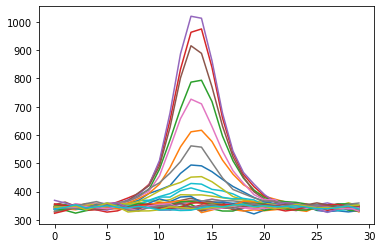

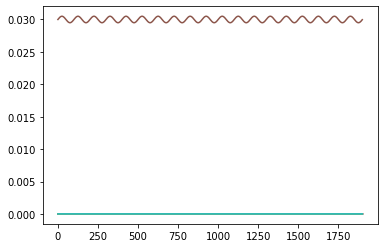

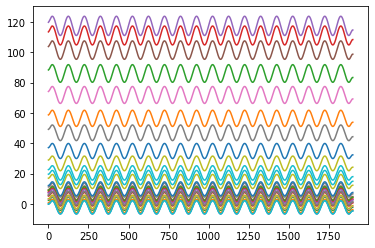

In [23]:
showGraph(np.transpose(star))
showGraph(np.transpose(line))
showGraph(np.transpose(line_convolved))

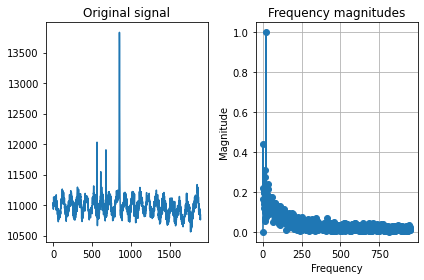

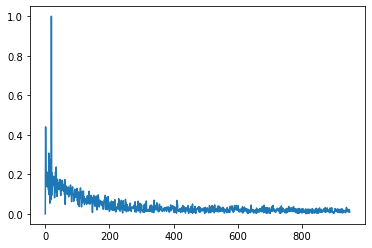

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


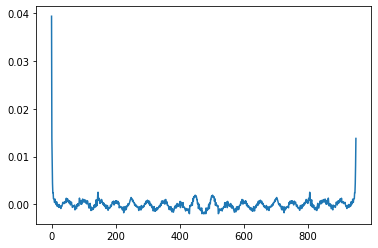

Inverse Fourier signal

The strongest frequency is f = 19.020021074815595


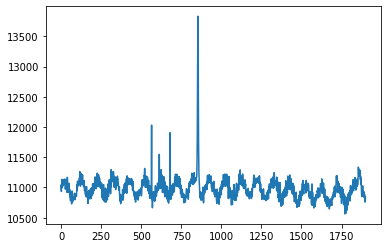

[ 1.32194452e+02  9.97116442e-03 -2.84622385e-02  1.09818126e+04]


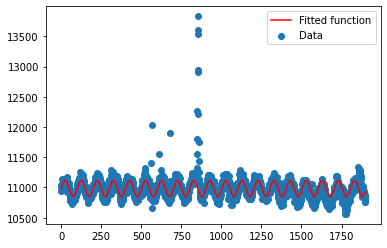

0.009971164424149326

In [24]:
data_with_line = addLineOnData(line_convolved, data)
findIntensityAlongTheLine(data_with_line, height_line, width_line, 100, 100)

In [54]:
scaled_data = scale_image(data_with_line[::-1].copy())
createImage('try_image_line.png', scaled_data)

/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:51: RuntimeWarning: invalid value encountered in greater
  raw_img[raw_img > z2] = z2
/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:52: RuntimeWarning: invalid value encountered in less
  raw_img[raw_img < z1] = z1
Lossy conversion from >f8 to uint8. Range [308.9854434077432, 399.421639764574]. Convert image to uint8 prior to saving to suppress this warning.


## Rotation of the generated line

In [91]:
radius = 15
width_line = 1900
height_line = 2*radius
#angle = randrange(0,359)
angle = 356
#angle = 339 interesting because cross a star
print('angle : '+str(angle))
line_rotated = ndimage.rotate(line_convolved, angle, reshape='False')
line_rotated_not_c = ndimage.rotate(line, angle, reshape='False')
data_with_rotated_line = addLineOnData(line_rotated, data)
scaled_data_rot = scale_image(data_with_rotated_line[::-1].copy())
createImage('report_line_rotated.png', scaled_data_rot)
#findIntensityAlongTheLine(data_with_line, height_line, width, 100, 100)
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data_with_rotated_line, 100, 100)
#createImage('line_from_image.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle, reshape='False')
#createImage('line_from_image_rot.png', line_from_image_rot)
#scaled_data_rot = scale_image(line_from_image_rot[::-1].copy())
#createImage('rot.png', scaled_data_rot)
#print(line_from_image_rot)

angle : 356


/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:51: RuntimeWarning: invalid value encountered in greater
  raw_img[raw_img > z2] = z2
/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:52: RuntimeWarning: invalid value encountered in less
  raw_img[raw_img < z1] = z1
Lossy conversion from >f8 to uint8. Range [308.9854434077432, 399.28893834276965]. Convert image to uint8 prior to saving to suppress this warning.


(294, 1904)


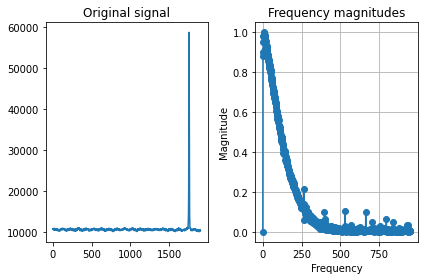

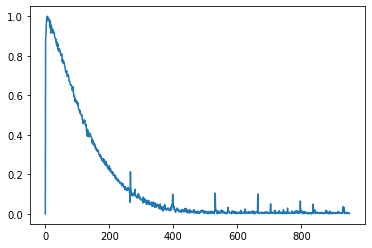

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


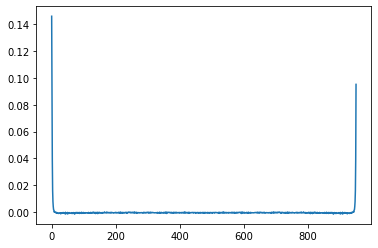

Inverse Fourier signal

The strongest frequency is f = 7.007360672975815


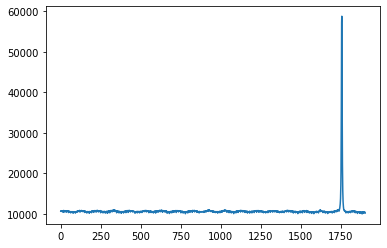

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [68]:
print(np.shape(line_from_image_rot))
for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

In [65]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
radius = 15
width_line = 1900
height_line = 2*radius
x_star,y_star = 1665,8346
value = 0.01 #number2
ampl, freq, phase_shift, vertical_shift = 0.05, 0.01, 0, 3 #number2
data = fits.open(name_file)[0].data
star = data[y_star-radius:y_star+radius, x_star-radius:x_star+radius]
line = np.zeros((height_line, width_line))

for i in range(height_line):
    for j in range(width_line):
        if(i == round(height_line/2)):
            line[i,j] = value*sinus(j, ampl, freq, phase_shift, vertical_shift)

line_convolved = ndimage.convolve(line, star)
line_convolved[-1,:] = line_convolved[0,:]
line_convolved[:,:] = line_convolved[:,:]-(51.4*6) #number2

result_by_angle = []

for angle in range(359):
    print('angle : '+str(angle))
    line_rotated = ndimage.rotate(line_convolved, angle, reshape='False')
    line_rotated_not_c = ndimage.rotate(line, angle, reshape='False')
    data_with_rotated_line = addLineOnData(line_rotated, data)
    line_mask = np.ones((height_line, width_line))
    line_mask_rotated = ndimage.rotate(line_mask, angle, reshape='False')
    line_from_image = get_line_values_with_mask(line_mask_rotated, data_with_rotated_line, 100, 100)
    line_from_image_rot = ndimage.rotate(line_from_image, 360-angle, reshape='False')
    for i in range(15):
        line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
        line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

    rot_height, rot_width = np.shape(line_from_image_rot)

    result_by_angle.append(findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0, False))
    print('result : '+str(result_by_angle[angle]))
print(result_by_angle)

angle : 0
The strongest frequency is f = 19.020021074815595
[ 1.30391777e+02  9.97774601e-03 -7.36699868e-02  1.06477635e+04]
result : 0.009977746010394698
angle : 1
The strongest frequency is f = 19.030031612223397
[ 1.25657879e+02  9.97809266e-03 -2.42689043e-02  1.06357388e+04]
result : 0.009978092661990616
angle : 2
The strongest frequency is f = 19.02
[1.28949884e+02 9.98057447e-03 4.36784353e-03 1.06345408e+04]
result : 0.009980574473232097
angle : 3
The strongest frequency is f = 19.009989484752893
[ 1.59652386e+02  9.99612991e-03 -9.04774836e-02  1.06414571e+04]
result : 0.00999612991315996
angle : 4
The strongest frequency is f = 19.019978969505782
[ 1.41225719e+03  1.01200387e-02 -1.14274446e+00  1.13153036e+04]
result : 0.010120038671749102
angle : 5
The strongest frequency is f = 4.006309148264984
[-1.29594601e+03  1.95991654e-03 -7.16445468e-01  1.13099768e+04]
result : 0.001959916538036965
angle : 6
The strongest frequency is f = 19.019957983193276
[ 1.61284282e+02  1.014

The strongest frequency is f = 19.019730010384215
[ 1.38834098e+02  9.98761204e-03 -7.63963923e-01  1.06129119e+04]
result : 0.009987612042654418
angle : 54
The strongest frequency is f = 19.029595015576323
[ 1.39197787e+02  9.99352074e-03 -8.29717390e-01  1.06131238e+04]
result : 0.00999352073781878
angle : 55
The strongest frequency is f = 19.019730010384215
[ 1.34115972e+02  9.98760308e-03 -7.80992733e-01  1.06120217e+04]
result : 0.009987603079930723
angle : 56
The strongest frequency is f = 1.0010384215991692
[-3.18863430e+02  5.73689474e-04 -6.04407879e-01  1.07473924e+04]
result : 0.0005736894742455949
angle : 57
The strongest frequency is f = 1.0010384215991692
[-3.87217833e+02  5.68795123e-04 -5.95202299e-01  1.07771346e+04]
result : 0.0005687951233471304
angle : 58
The strongest frequency is f = 19.009865005192108
[ 1.50154076e+02  1.00244390e-02 -8.26702712e-01  1.06256696e+04]
result : 0.010024438996777109
angle : 59
The strongest frequency is f = 19.01975051975052
[ 1.3369

The strongest frequency is f = 19.01985370950888
[ 1.46046088e+02  9.98235544e-03 -2.83862643e-01  1.06195694e+04]
result : 0.009982355444912433
angle : 107
The strongest frequency is f = 19.029780564263323
[ 1.31659947e+02  1.00065172e-02 -5.74479108e-01  1.06215959e+04]
result : 0.010006517169149685
angle : 108
The strongest frequency is f = 19.029780564263323
[ 1.45123776e+02  9.98841155e-03 -4.05049450e-01  1.06129528e+04]
result : 0.009988411546719254
angle : 109
The strongest frequency is f = 19.01983298538622
[ 1.58934778e+02  9.98895096e-03 -4.08256399e-01  1.06250479e+04]
result : 0.009988950963328847
angle : 110
The strongest frequency is f = 19.01981230448384
[ 1.49827314e+02  9.96603981e-03 -3.13998676e-01  1.06085593e+04]
result : 0.009966039805517645
angle : 111
The strongest frequency is f = 19.029718456725753
[ 1.42961687e+02  9.97737361e-03 -4.70841895e-01  1.06024686e+04]
result : 0.009977373613289386
angle : 112
The strongest frequency is f = 19.029718456725753
[ 1.5

The strongest frequency is f = 3.0046923879040666
[-6.35053120e+02  1.87540705e-03 -1.00689266e+00  1.09684167e+04]
result : 0.0018754070541188643
angle : 160
The strongest frequency is f = 19.01981230448384
[1.59031764e+02 9.78092455e-03 1.27444568e+00 1.07085000e+04]
result : 0.009780924547311935
angle : 161
The strongest frequency is f = 19.01983298538622
[ 1.66075651e+02  9.96807063e-03 -2.60164302e-01  1.06707262e+04]
result : 0.009968070631250568
angle : 162
The strongest frequency is f = 19.029780564263323
[ 1.36536517e+02  9.95065726e-03 -3.10726063e-01  1.06838077e+04]
result : 0.009950657255346614
angle : 163
The strongest frequency is f = 2.0031347962382444
[3.99344071e+02 1.20313593e-03 3.18328959e+00 1.08532436e+04]
result : 0.0012031359298259236
angle : 164
The strongest frequency is f = 2.0020898641588296
[1.70500251e+03 1.22919971e-03 2.93633384e+00 1.15925503e+04]
result : 0.0012291997141128
angle : 165
The strongest frequency is f = 6.003134796238244
[-2.03873882e+03 

The strongest frequency is f = 19.009865005192108
[ 1.31318129e+02  9.98650244e-03 -6.84458671e-01  1.06324437e+04]
result : 0.009986502439227498
angle : 213
The strongest frequency is f = 19.019730010384215
[ 1.27195358e+02  9.96749208e-03 -7.44014686e-01  1.06284264e+04]
result : 0.009967492075580786
angle : 214
The strongest frequency is f = 19.019730010384215
[ 2.50558058e+02  9.86727526e-03 -4.27759842e-01  1.06937764e+04]
result : 0.009867275255573993
angle : 215
The strongest frequency is f = 19.019730010384215
[ 3.24391116e+02  9.96367177e-03 -7.46317212e-01  1.07165758e+04]
result : 0.009963671768760942
angle : 216
The strongest frequency is f = 19.029595015576323
[ 1.45207318e+02  1.00047347e-02 -9.12355705e-01  1.06188575e+04]
result : 0.010004734732195285
angle : 217
The strongest frequency is f = 19.019730010384215
[ 1.51281079e+02  9.99238647e-03 -7.55201185e-01  1.06203727e+04]
result : 0.009992386472826189
angle : 218
The strongest frequency is f = 19.029595015576323
[ 

The strongest frequency is f = 19.029968454258675
[ 1.24419065e+02  1.00409984e-02 -4.68686345e-01  1.06336961e+04]
result : 0.0100409983570168
angle : 266
The strongest frequency is f = 19.019978969505782
[ 1.73648470e+02  1.00093353e-02 -2.02817488e-01  1.06382205e+04]
result : 0.01000933531242933
angle : 267
The strongest frequency is f = 19.009989484752893
[ 1.72739967e+02  1.00572799e-02 -6.56130538e-01  1.06328308e+04]
result : 0.010057279906108135
angle : 268
The strongest frequency is f = 19.02
[1.44505752e+02 9.98413062e-03 1.40785727e-01 1.06052215e+04]
result : 0.009984130615564307
angle : 269
The strongest frequency is f = 19.030031612223397
[1.30310479e+02 9.81108054e-03 1.54873733e+00 1.06393815e+04]
result : 0.009811080539362093
angle : 270
The strongest frequency is f = 10.010537407797681
[1.38721841e+02 5.04786496e-03 2.13715475e+00 1.06745567e+04]
result : 0.005047864964227773
angle : 271
The strongest frequency is f = 10.015806111696524
[1.19774267e+02 5.47604741e-03

The strongest frequency is f = 7.007261410788382
[-1.79712289e+02  3.66180785e-03  1.01393073e+00  1.07163714e+04]
result : 0.0036618078454186713
angle : 319
The strongest frequency is f = 13.013485477178424
[2.32983272e+02 6.76980149e-03 3.04881926e-01 1.07221093e+04]
result : 0.006769801490635555
angle : 320
The strongest frequency is f = 19.019709543568464
[ 1.51655896e+02  1.00728605e-02 -1.61142131e+00  1.06386752e+04]
result : 0.010072860547997923
angle : 321
The strongest frequency is f = 19.029595015576323
[ 1.22930634e+02  1.00478033e-02 -1.33083547e+00  1.06139253e+04]
result : 0.01004780334612577
angle : 322
The strongest frequency is f = 19.029595015576323
[ 1.30182274e+02  1.00185310e-02 -1.16952749e+00  1.06179382e+04]
result : 0.010018531027567253
angle : 323
The strongest frequency is f = 19.019730010384215
[ 3.36965347e+02  9.97649162e-03 -8.36002913e-01  1.07126203e+04]
result : 0.009976491616135905
angle : 324
The strongest frequency is f = 19.029595015576323
[ 1.412

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

360


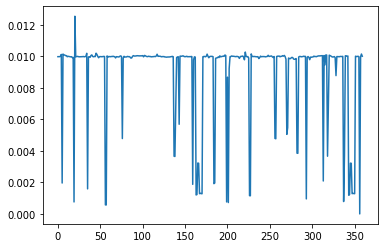

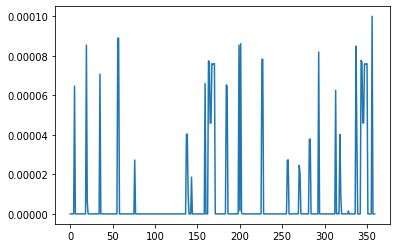

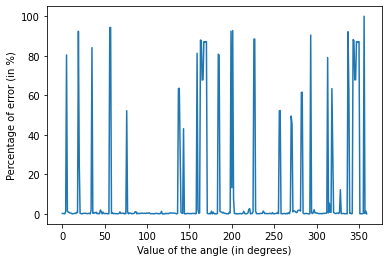

7.679476381360366e-06
10.135722687515612


In [90]:
print(len(result_by_angle))
showGraph(result_by_angle)
square_error_by_angle = []
error_in_percent = []
for res in result_by_angle:
    square_error_by_angle.append((freq-res)**2)
    error_in_percent.append(abs(freq-res)/freq*100)
showGraph(square_error_by_angle)
plt.figure()
plt.plot(error_in_percent)
plt.xlabel('Value of the angle (in degrees)')
plt.ylabel('Percentage of error (in %)')
plt.show()
mean_square_error = np.array(square_error_by_angle).mean()
mean_error_percent = np.array(error_in_percent).mean()
print(mean_square_error)
print(mean_error_percent)

# On Real Data

# On OMEGA.2020-02-22T02:11:36.295_fullfield

Lossy conversion from float64 to uint8. Range [0.0, 621.3670015116414]. Convert image to uint8 prior to saving to suppress this warning.


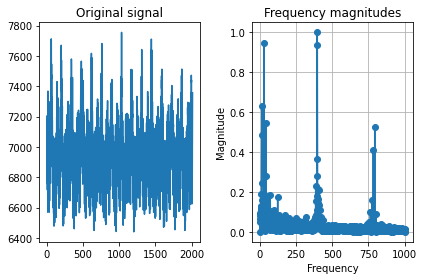

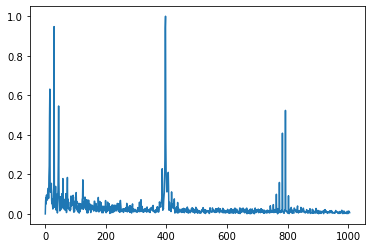

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


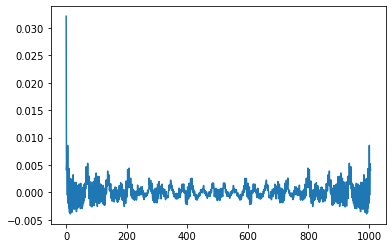

Inverse Fourier signal

The strongest frequency is f = 29.028855721393032


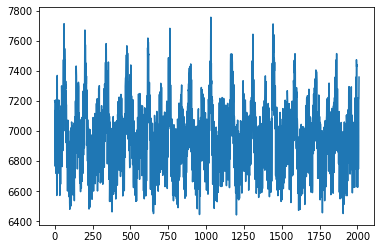

[-1.27550247e+02  1.44517578e-02 -1.44642610e+00  6.98257327e+03]


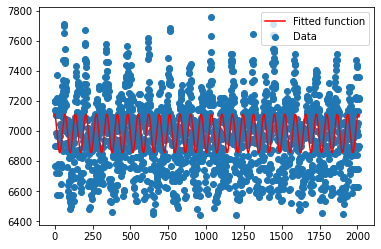

rotation rate found : 1.2085218097494037 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [27]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 7302, 7697

start_line_x, start_line_y = 60, int(center_line_start_y-radius)
end_line_x, end_line_y = 2025, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data2.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 2620.4216272931085]. Convert image to uint8 prior to saving to suppress this warning.


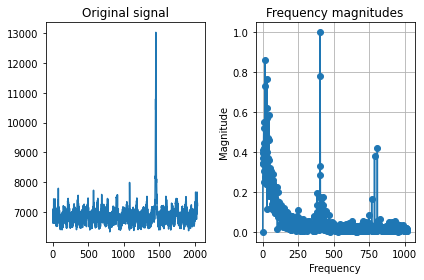

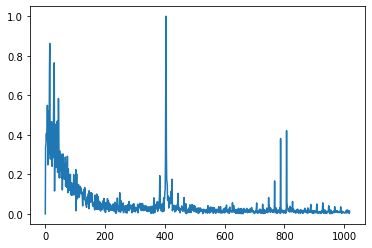

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


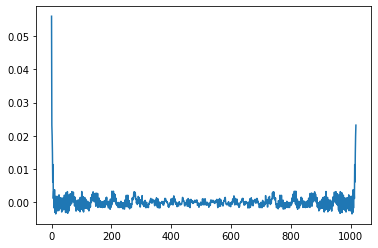

Inverse Fourier signal

The strongest frequency is f = 15.014734774066799


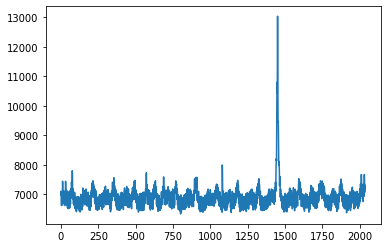

[-1.58341436e+02  7.16063970e-03  2.32175475e+00  6.93682842e+03]


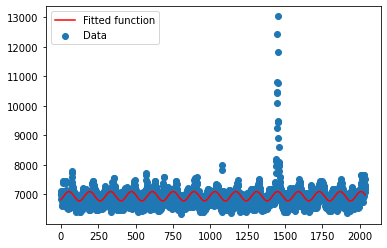

rotation rate found : 0.5988053042396322 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [28]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 7732, 8134

start_line_x, start_line_y = 2216, int(center_line_start_y-radius)
end_line_x, end_line_y = 4206, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 1630.3802590439227]. Convert image to uint8 prior to saving to suppress this warning.


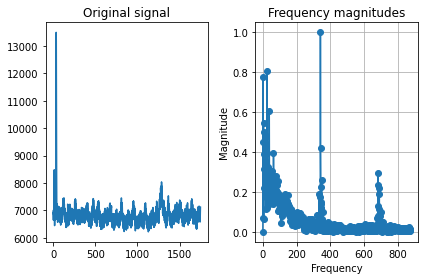

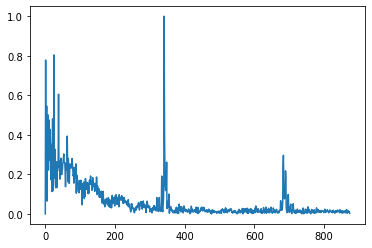

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


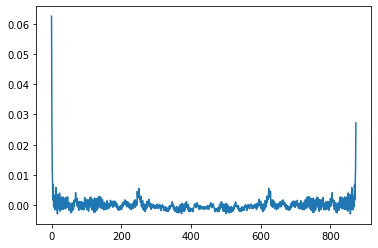

Inverse Fourier signal

The strongest frequency is f = 25.014318442153495


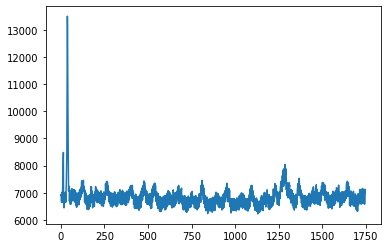

[-1.35236581e+02  1.43325831e-02  5.73146515e-01  6.87039511e+03]


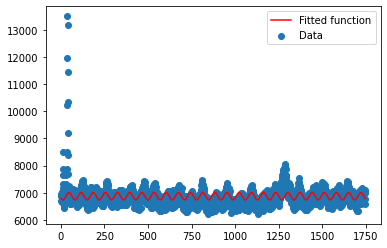

rotation rate found : 1.1985558765274238 [1/s]
spatial rotation scale found : 174.53292519943298 [m/arc second]


In [29]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 8158, 8498

start_line_x, start_line_y = 4340, int(center_line_start_y-radius)
end_line_x, end_line_y = 6047, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 4839.538431445714]. Convert image to uint8 prior to saving to suppress this warning.


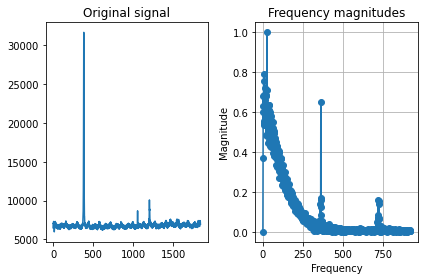

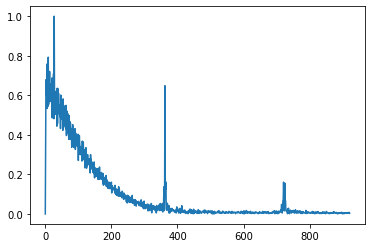

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


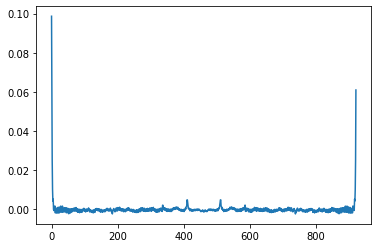

Inverse Fourier signal

The strongest frequency is f = 27.02931596091205


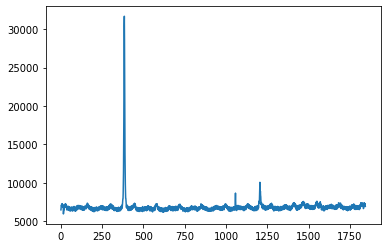

[-3.06090875e+02  1.45426007e-02  1.23606325e+00  6.91468934e+03]


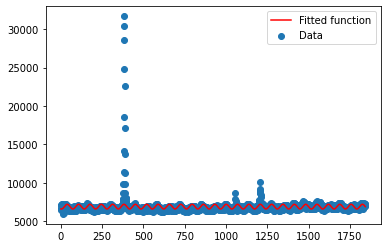

rotation rate found : 1.2161185026016013 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [30]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 8609, 8970

start_line_x, start_line_y = 6599, int(center_line_start_y-radius)
end_line_x, end_line_y = 8401, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

# On OMEGA.2020-02-22T02:05:31.174_fullfield

Lossy conversion from float64 to uint8. Range [0.0, 980.6608138045503]. Convert image to uint8 prior to saving to suppress this warning.


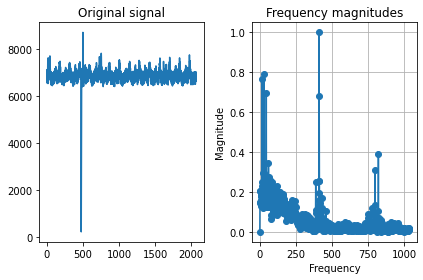

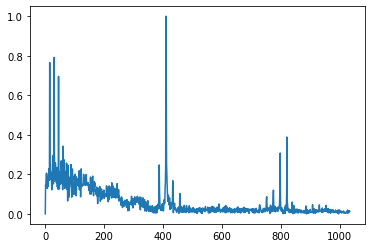

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


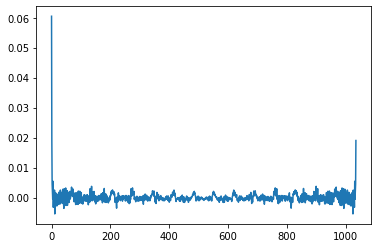

Inverse Fourier signal

The strongest frequency is f = 30.029013539651835


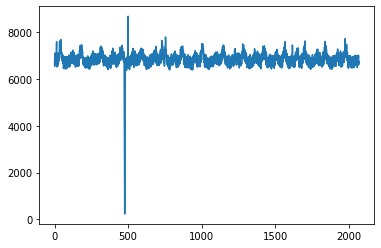

[-1.31728340e+02  1.43841884e-02  1.31027494e+00  6.89600573e+03]


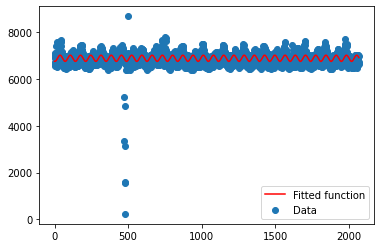

rotation rate found : 1.202871343630387 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [31]:
name_file = 'detectsat/OMEGA.2020-02-22T02:05:31.174_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 9286, 9695

start_line_x, start_line_y = 10732, int(center_line_start_y-radius)
end_line_x, end_line_y = 12754, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 540.8346472884411]. Convert image to uint8 prior to saving to suppress this warning.


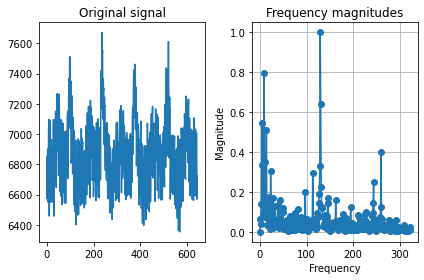

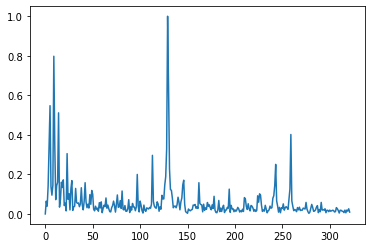

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


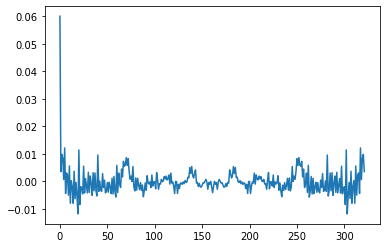

Inverse Fourier signal

The strongest frequency is f = 9.028037383177569


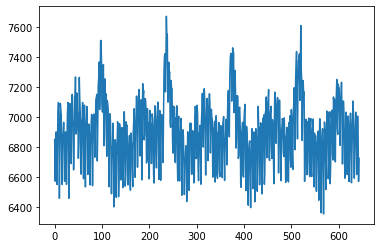

[ 1.30105656e+02  1.43384770e-02 -1.40822179e+00  6.90041698e+03]


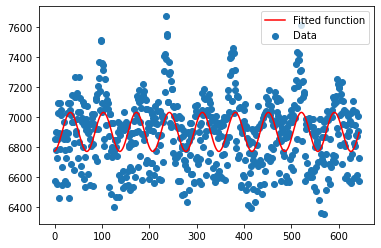

rotation rate found : 1.199048749386 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [32]:
name_file = 'detectsat/OMEGA.2020-02-22T02:05:31.174_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 9137, 9265

start_line_x, start_line_y = 9992, int(center_line_start_y-radius)
end_line_x, end_line_y = 10616, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 642.1696133010005]. Convert image to uint8 prior to saving to suppress this warning.


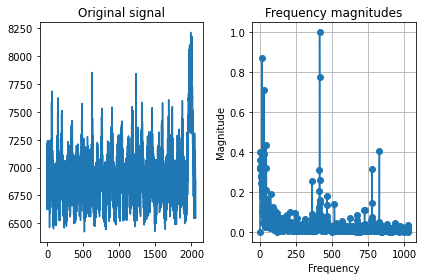

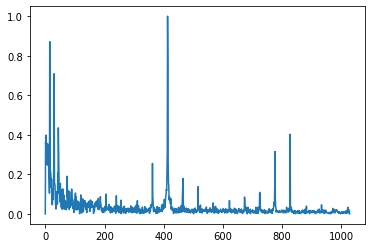

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


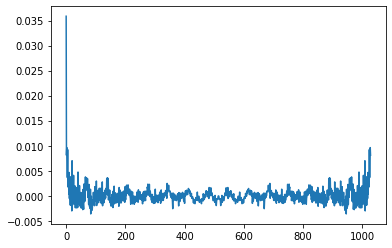

Inverse Fourier signal

The strongest frequency is f = 15.014591439688715


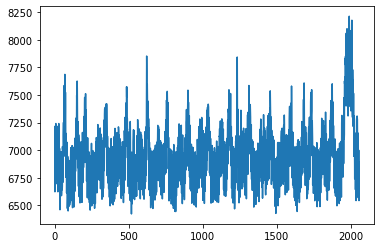

[ 1.33729969e+02  7.23033937e-03 -8.67774715e-01  6.97555535e+03]


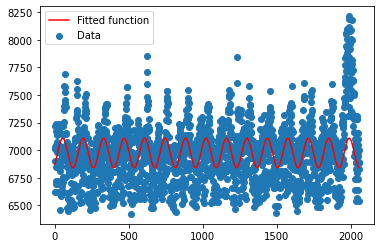

rotation rate found : 0.6046339082804881 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [33]:
name_file = 'detectsat/OMEGA.2020-02-22T02:05:31.174_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 9720, 10132

start_line_x, start_line_y = 12879, int(center_line_start_y-radius)
end_line_x, end_line_y = 14888, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 592.1015457690042]. Convert image to uint8 prior to saving to suppress this warning.


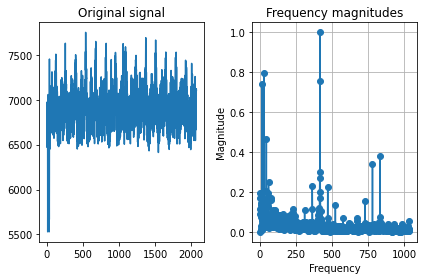

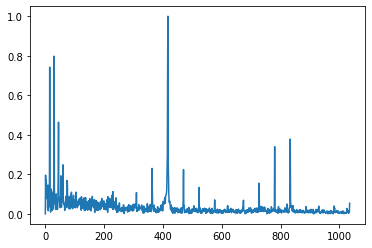

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


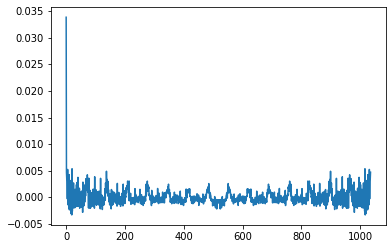

Inverse Fourier signal

The strongest frequency is f = 30.02898550724638


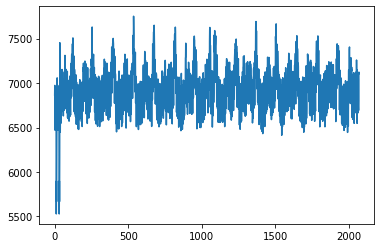

[-1.27255351e+02  1.43917515e-02 -2.17109693e-01  6.95445490e+03]


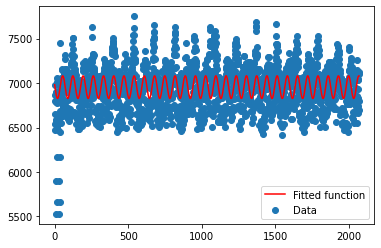

rotation rate found : 1.2035038092026644 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [34]:
name_file = 'detectsat/OMEGA.2020-02-22T02:05:31.174_fullfield.fits'
radius = 10
center_line_start_y, center_line_end_y = 10153, 10568

start_line_x, start_line_y = 14999, int(center_line_start_y-radius)
end_line_x, end_line_y = 17021, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

# On OMEGA.2020-03-17T01_04_10.476_fullfield_binned

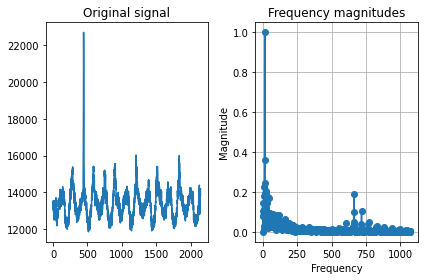

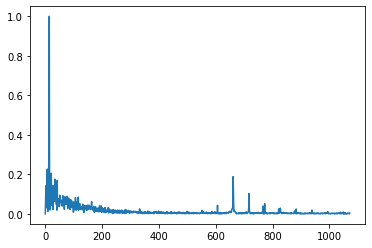

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


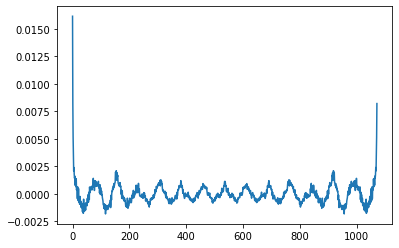

Inverse Fourier signal

The strongest frequency is f = 14.013071895424837


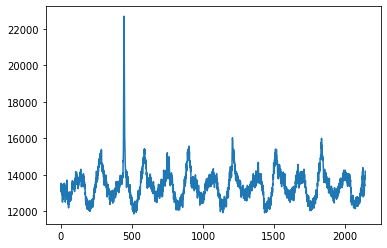

[-9.16093805e+02  6.41085754e-03 -3.85923830e-01  1.34342771e+04]


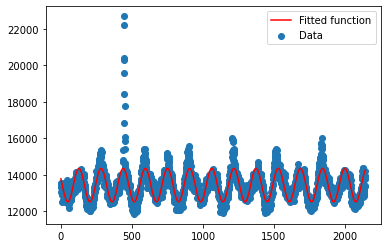

rotation rate found : 0.5361051048353588 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [52]:
name_file = 'images/satellites/OMEGA.2020-03-17T01_04_10.476_fullfield_binned.fits'
radius = 13
center_line_start_y, center_line_end_y = 1020, 1677

start_line_x, start_line_y = 6412, int(center_line_start_y-radius)
end_line_x, end_line_y = 8438, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
#scaled_data = scale_image(line_from_image[::-1].copy())
#createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

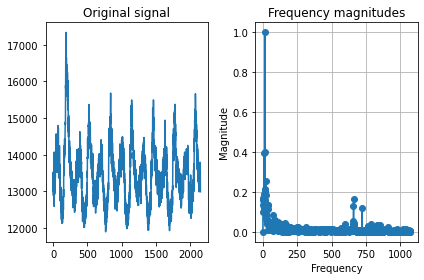

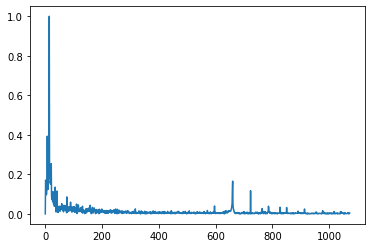

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


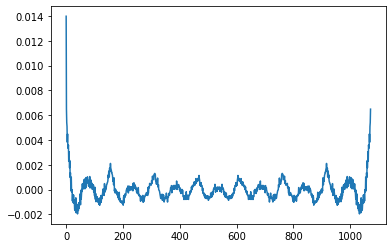

Inverse Fourier signal

The strongest frequency is f = 14.013059701492537


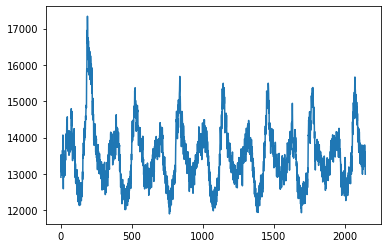

[ 8.83792379e+02  6.39839619e-03 -7.82433529e-01  1.34916106e+04]


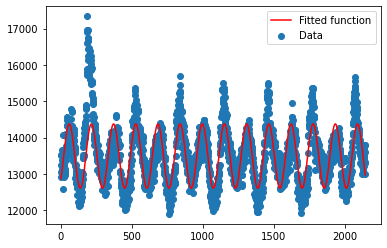

rotation rate found : 0.5350630301111444 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [53]:
name_file = 'images/satellites/OMEGA.2020-03-17T01_04_10.476_fullfield_binned.fits'
radius = 13
center_line_start_y, center_line_end_y = 1714, 2369

start_line_x, start_line_y = 8544, int(center_line_start_y-radius)
end_line_x, end_line_y = 10572, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
#scaled_data = scale_image(line_from_image[::-1].copy())
#createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

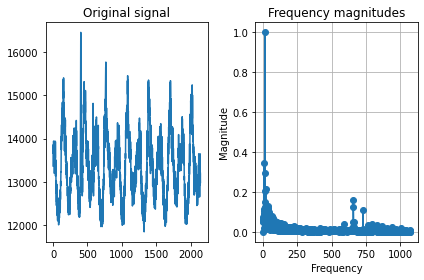

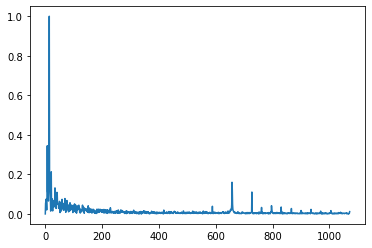

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


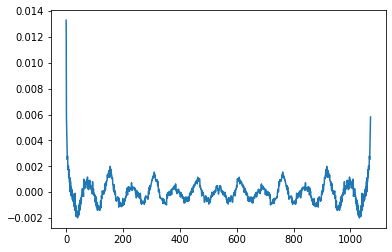

Inverse Fourier signal

The strongest frequency is f = 14.019607843137255


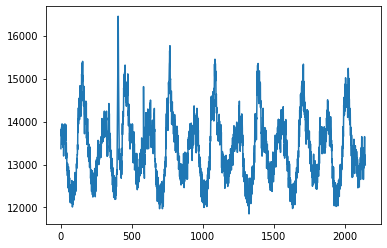

[8.59524481e+02 6.42039770e-03 1.70755778e+00 1.34027665e+04]


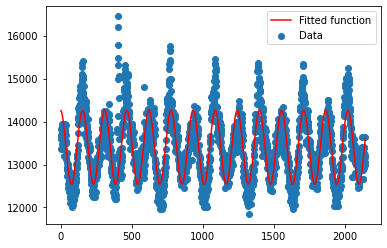

rotation rate found : 0.5369028967805078 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [54]:
name_file = 'images/satellites/OMEGA.2020-03-17T01_04_10.476_fullfield_binned.fits'
radius = 13
center_line_start_y, center_line_end_y = 2407, 3060

start_line_x, start_line_y = 10680, int(center_line_start_y-radius)
end_line_x, end_line_y = 12708, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
#scaled_data = scale_image(line_from_image[::-1].copy())
#createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

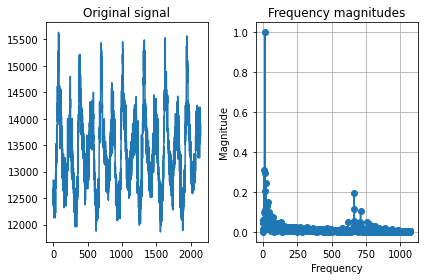

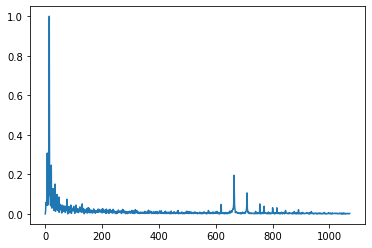

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


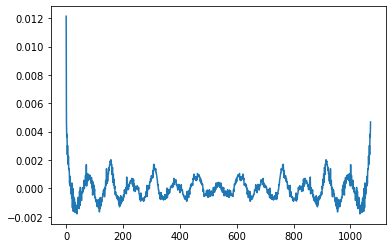

Inverse Fourier signal

The strongest frequency is f = 14.013071895424837


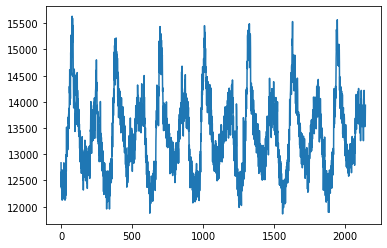

[-8.64793388e+02  6.42383739e-03  1.20837489e+00  1.34015516e+04]


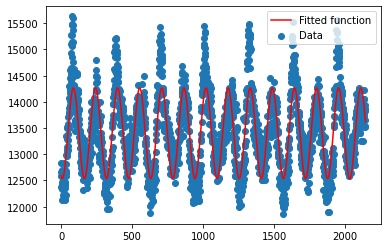

rotation rate found : 0.5371905391900738 [1/s]
spatial rotation scale found : 174.53292519943298 [m/arc second]


In [55]:
name_file = 'images/satellites/OMEGA.2020-03-17T01_04_10.476_fullfield_binned.fits'
radius = 13
center_line_start_y, center_line_end_y = 3099, 3759

start_line_x, start_line_y = 12817, int(center_line_start_y-radius)
end_line_x, end_line_y = 14842, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
#scaled_data = scale_image(line_from_image[::-1].copy())
#createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

 # On OMEGA.2020-01-28T03_23_35.394_fullfield_binned.fits

## Too weak intensity

Lossy conversion from float64 to uint8. Range [0.0, 363.2972798090182]. Convert image to uint8 prior to saving to suppress this warning.


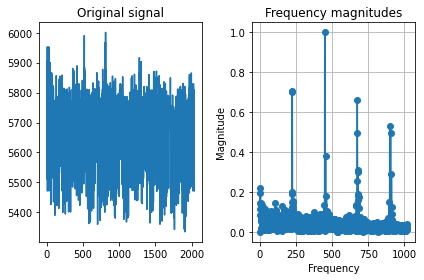

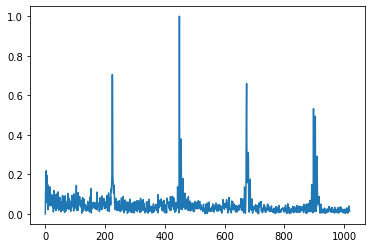

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


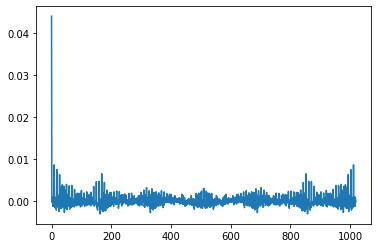

Inverse Fourier signal

The strongest frequency is f = 3.0014720314033365


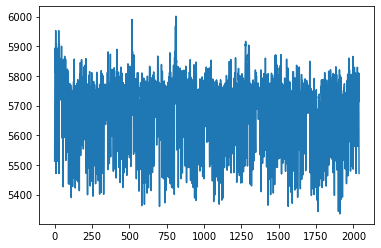

[1.32049630e+01 1.43605643e-03 1.37006175e+00 5.70557302e+03]


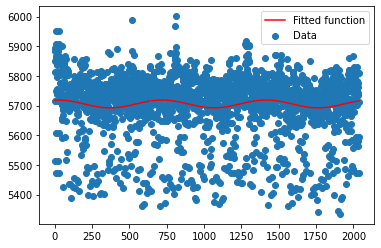

rotation rate found : 0.120089579407323 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [24]:
name_file = 'images/satellites/OMEGA.2020-01-28T03_23_35.394_fullfield_binned.fits'
radius = 10
center_line_start_y, center_line_end_y = 11390, 11614

start_line_x, start_line_y = 14951, int(center_line_start_y-radius)
end_line_x, end_line_y = 16973, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 1977.3150291215873]. Convert image to uint8 prior to saving to suppress this warning.


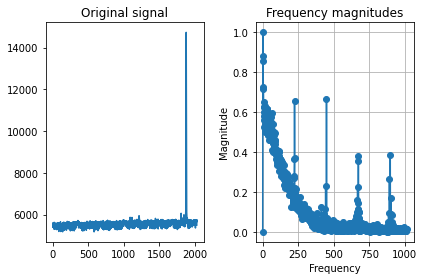

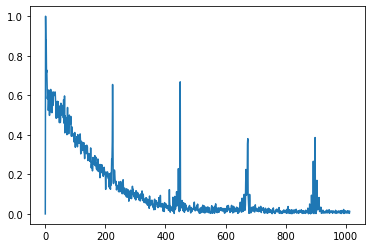

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


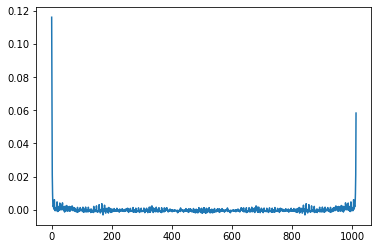

Inverse Fourier signal

The strongest frequency is f = 1.0004935834155972


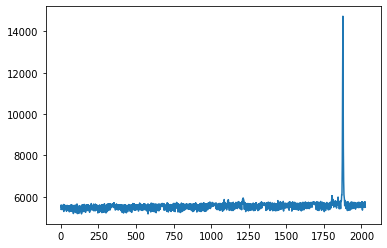

[-2.15668851e+05  4.82663691e-06  1.56257316e+00  2.21191654e+05]


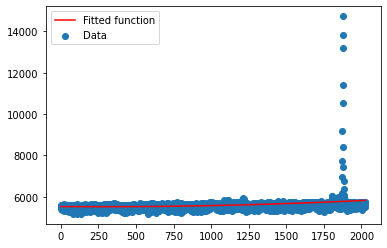

rotation rate found : 0.00040362536111418 [1/s]
spatial rotation scale found : 174.53292519943298 [m/arc second]


In [25]:
name_file = 'images/satellites/OMEGA.2020-01-28T03_23_35.394_fullfield_binned.fits'
radius = 10
center_line_start_y, center_line_end_y = 10444, 10668

start_line_x, start_line_y = 6419, int(center_line_start_y-radius)
end_line_x, end_line_y = 8429, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

# On OMEGA.2020-01-29T04_03_55.177_fullfield_binned.fits

## Too much noise

In [33]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
data = fits.open(name_file)[0].data
display_image = scale_image(data[::-1].copy())
createImage('OMEGA.2020-02-22T02:11:36.295_fullfield.png', display_image)

Lossy conversion from >f8 to uint8. Range [308.9854434077432, 399.28893834276965]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0.0, 3929.7238827389024]. Convert image to uint8 prior to saving to suppress this warning.


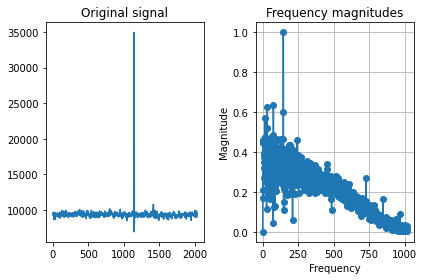

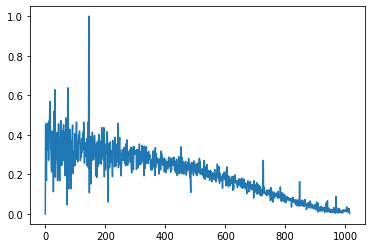

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


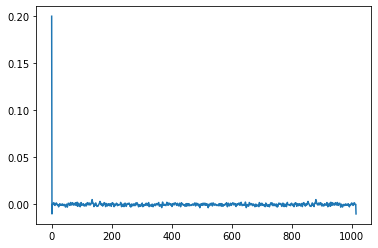

Inverse Fourier signal

The strongest frequency is f = 75.03694581280787


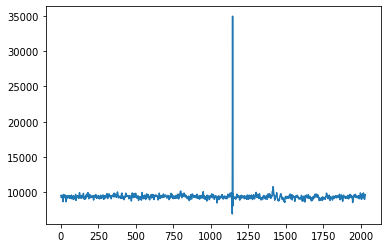

[ 8.64944669e+01  3.69679227e-02 -4.98788583e-01  9.39627588e+03]


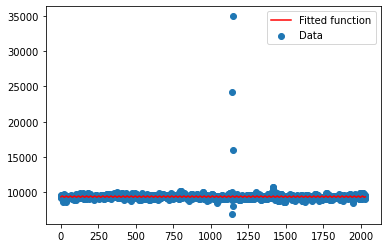

rotation rate found : 3.0914260608637507 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [26]:
name_file = 'images/satellites/OMEGA.2020-01-29T04_03_55.177_fullfield_binned.fits'
radius = 10
center_line_start_y, center_line_end_y = 14385, 14506

start_line_x, start_line_y = 10680, int(center_line_start_y-radius)
end_line_x, end_line_y = 12705, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 9273.303414345351]. Convert image to uint8 prior to saving to suppress this warning.


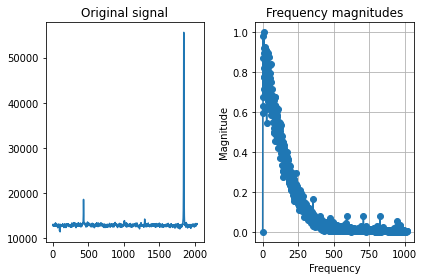

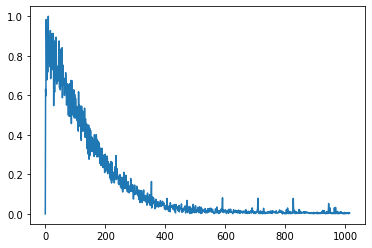

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


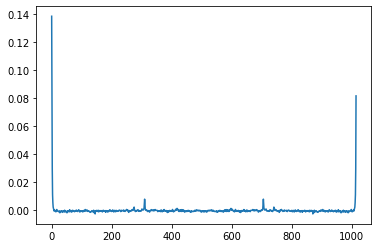

Inverse Fourier signal

The strongest frequency is f = 10.004926108374384


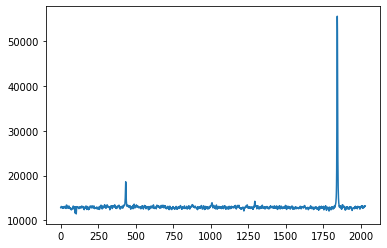

[3.19592748e+02 4.96716707e-03 5.13761084e-01 1.30639518e+04]


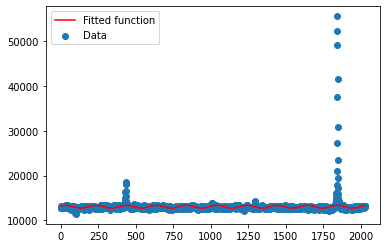

rotation rate found : 0.4153771329546372 [1/s]
spatial rotation scale found : 174.53292519943295 [m/arc second]


In [27]:
name_file = 'images/satellites/OMEGA.2020-01-29T04_03_55.177_fullfield_binned.fits'
radius = 15
center_line_start_y, center_line_end_y = 14510, 14628

start_line_x, start_line_y = 12816, int(center_line_start_y-radius)
end_line_x, end_line_y = 14841, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

Lossy conversion from float64 to uint8. Range [0.0, 21387.24349266804]. Convert image to uint8 prior to saving to suppress this warning.


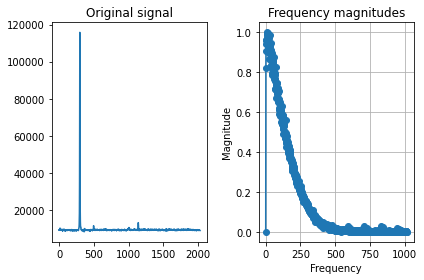

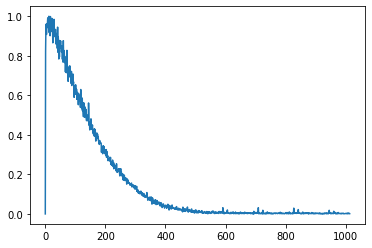

Frequency magnitudes



/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


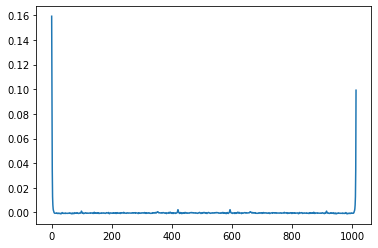

Inverse Fourier signal

The strongest frequency is f = 12.005923000987167


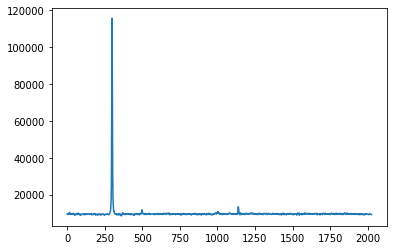

[-6.99564155e+02  5.69726383e-03  2.65272610e-01  9.83658708e+03]


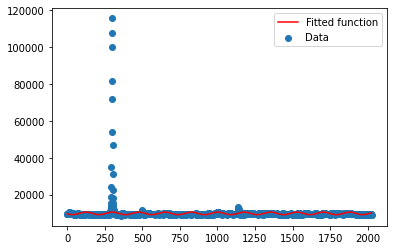

rotation rate found : 0.4764311487539634 [1/s]
spatial rotation scale found : 174.53292519943298 [m/arc second]


In [28]:
name_file = 'images/satellites/OMEGA.2020-01-29T04_03_55.177_fullfield_binned.fits'
radius = 10
center_line_start_y, center_line_end_y = 14632, 14750

start_line_x, start_line_y = 14952, int(center_line_start_y-radius)
end_line_x, end_line_y = 16973, int(center_line_end_y-radius)

angle_line = (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
angle_to_rotate = 360 - angle_line

width_line = int((end_line_x-start_line_x)/np.cos(math.radians(angle_line)))
height_line = 2*radius

data = fits.open(name_file)[1].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_to_rotate, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_to_rotate, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

freq_found = findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

# Calculation to cast the frequency found to real speed
rotation_rate, spatial_rotation_scale = recast_freq(freq_found)
print('rotation rate found : '+str(rotation_rate)+' [1/s]')
print('spatial rotation scale found : '+str(spatial_rotation_scale)+' [m/arc second]')

## Utils for Report

In [41]:
import cv2
from PIL import Image
#data = fits.open('detectsat/OMEGA.2020-03-17T01_04_10.476_fullfield_binned.fits')[0].data
data = fits.open('images/satellites/OMEGA.2020-03-17T01_04_10.476_fullfield_binned.fits')[1].data
#data = data[7105:9049, 52:8484]
data = data[1000:1700, 6412:8438]
data_n = scale_image(data[::-1].copy())
# x = 52 y = 7105
# x = 8484 y = 9049
#img = imgio.imread('OMEGA.2020-02-22T02:11:36.295_fullfield.png')
#img = cv2.resize(data_n, (500, 500))
#img = Image.fromarray(data_n).resize((500, 500))
createImage('test_debug.png', data_n)

Lossy conversion from >f8 to uint8. Range [417.5934839605107, 513.7597593369189]. Convert image to uint8 prior to saving to suppress this warning.
